In [2]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from time import perf_counter
import wandb
import numpy as np

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors

SAVE = False
PATH = "results/filter_order/"

## Auxiliary functions

In [3]:
def run(g, Ks, Exps, q_opt, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err1 = np.zeros((len(Exps), Ks.size))
    err2 = np.zeros((len(Exps), Ks.size))
    bell_err = np.zeros((len(Exps), Ks.size))
    
    use_logger = use_logger and g == 0

    for i, K in enumerate(Ks):
        K = int(K)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()
            
            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, env_test=env, K=K, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-K{K}",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=env, max_eval_iters=K)
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{K}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=exp['args']['max_epochs'], log_every_n_steps=log_every_n_steps, accelerator='cpu',
                                  logger=logger)
            else:
                raise Exception("Unknown model")

            trainer.fit(model)
            wandb.finish()

            err1[j,i], err2[j,i] = test_pol_err(model, q_opt)
            bell_err[j,i] = model.bellman_error.cpu().numpy()

            if verbose:
                print(f"- {g}. K {K}: Model: {exp['name']} Err1: {err1[j,i]:.3f} | bell_err: {bell_err[j,i]:.3f}")
    return err1, err2, bell_err


## Unrolls = 5

In [8]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 5
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=uxqg, bellman_error=0.000, policy_diff=2.830, q_norm=731.0]              

/home/srey/Investigacion/rl-unrolling/venv/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 142.20it/s, v_num=uxqg, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s, v_num=uxqg, bellman_error=0.000, policy_diff=0.000, q_norm=709.0] 


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
policy_diff,█▆▅▅▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


In [ ]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

Data saved as: results/filter_order/filter_order-5_data.npz


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-5_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

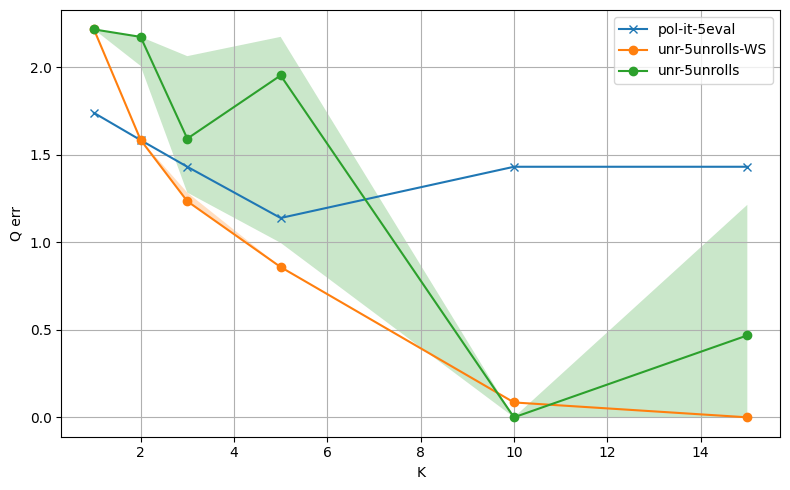

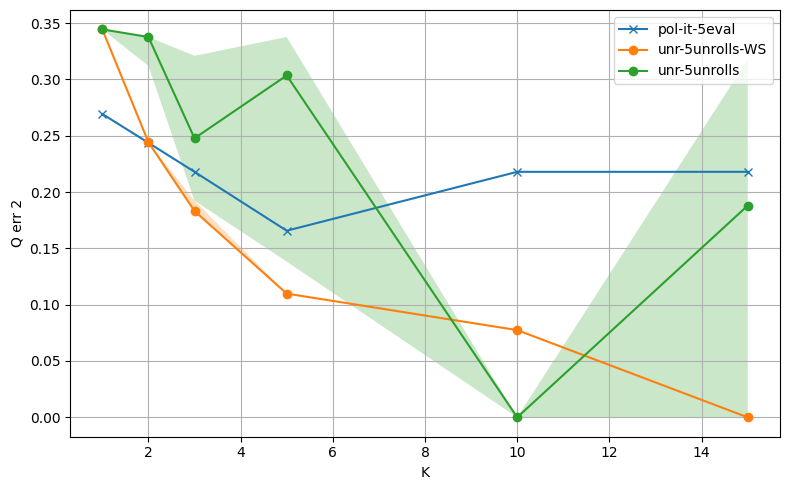

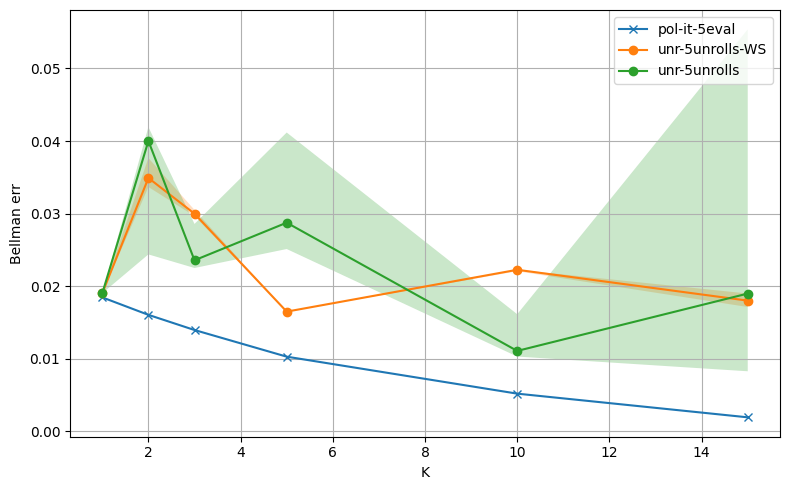

In [12]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Unrolls = 10

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 10
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

In [ ]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

Data saved as: results/filter_order/filter_order-10_data.npz


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-10_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

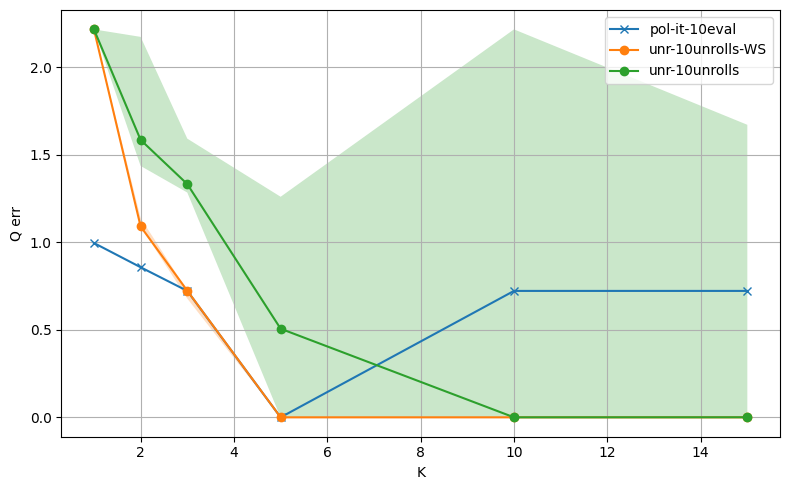

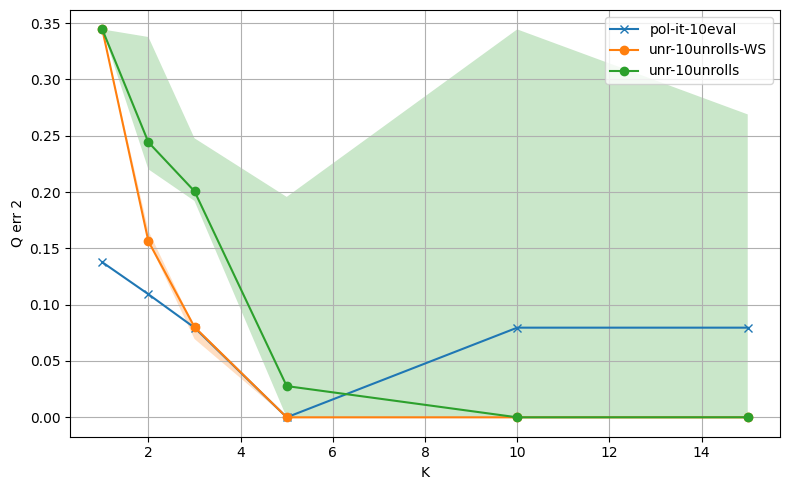

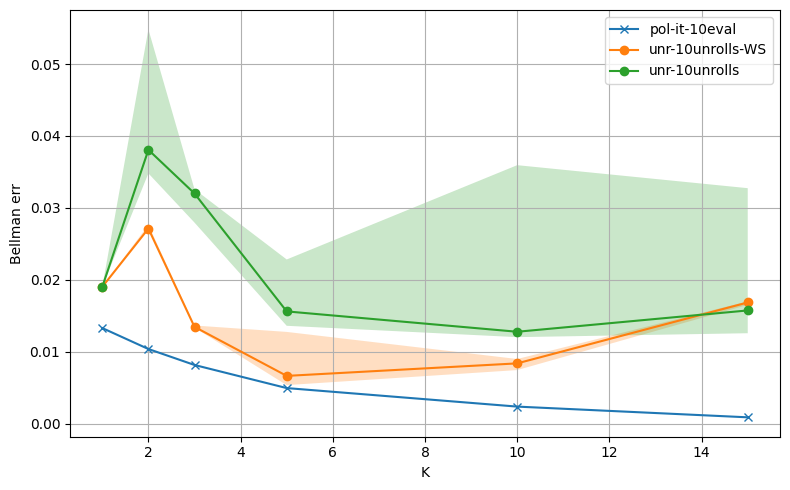

In [20]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Unrolls = 15

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
num_unrolls = 15
group_name = f"filter_order-{num_unrolls}"

Ks = np.array([1, 2, 3, 5, 10, 15]) # np.arange(1,30, 2)
Exps = [
    {"model": "pol-it", "args": {"max_epochs": num_unrolls}, "fmt": "x-", "name": f"pol-it-{num_unrolls}eval"},

    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls-WS"},
    {"model": "unroll", "args": {"num_unrolls": num_unrolls, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o-", "name": f"unr-{num_unrolls}unrolls"},

    # {"model": "unroll", "args": {"num_unrolls": 5, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-5unrolls"},
    # {"model": "unroll", "args": {"num_unrolls": 10, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "name": "unr-10unrolls"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

In [ ]:
n_runs = 5

errs1 = np.zeros((n_runs, len(Exps), Ks.size))
errs2 = np.zeros((n_runs, len(Exps), Ks.size))
bell_errs = np.zeros((n_runs, len(Exps), Ks.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, Ks, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, Ks=Ks, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

Data saved as: results/filter_order/filter_order-15_data.npz


In [ ]:
# # Load data
# data = np.load(PATH + "filter_order-15_data.npz", allow_pickle=True)
# Ks = data["Ks"]
# Exps = data["Exps"]
# errs1 = data["errs1"] 
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

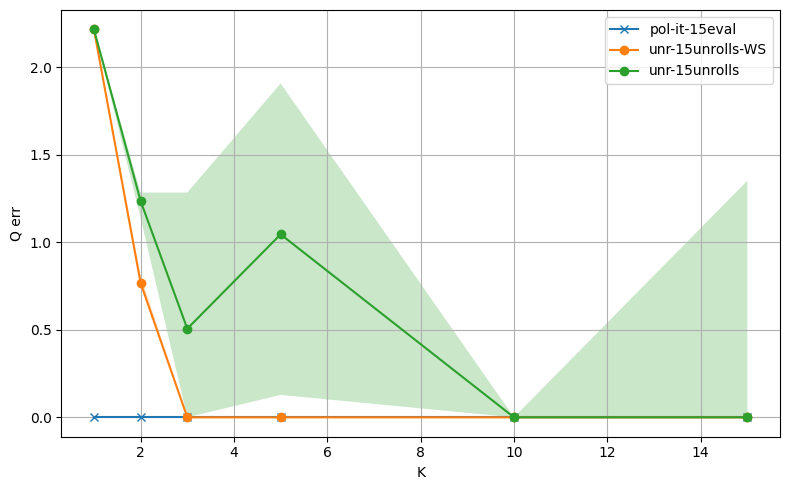

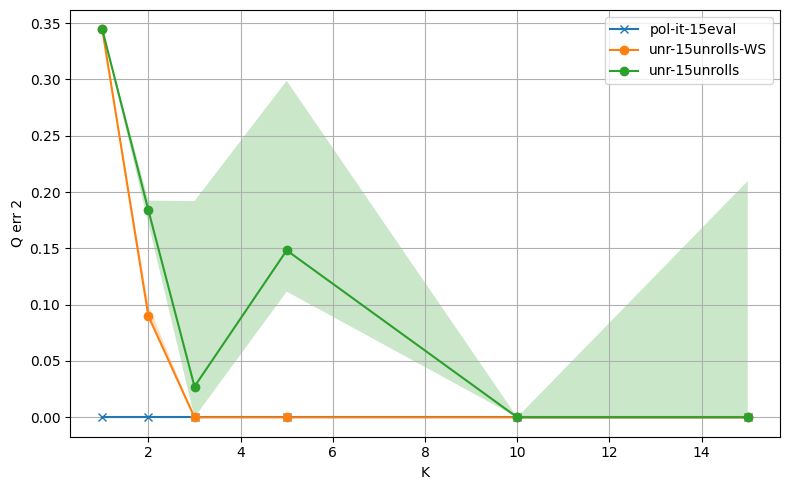

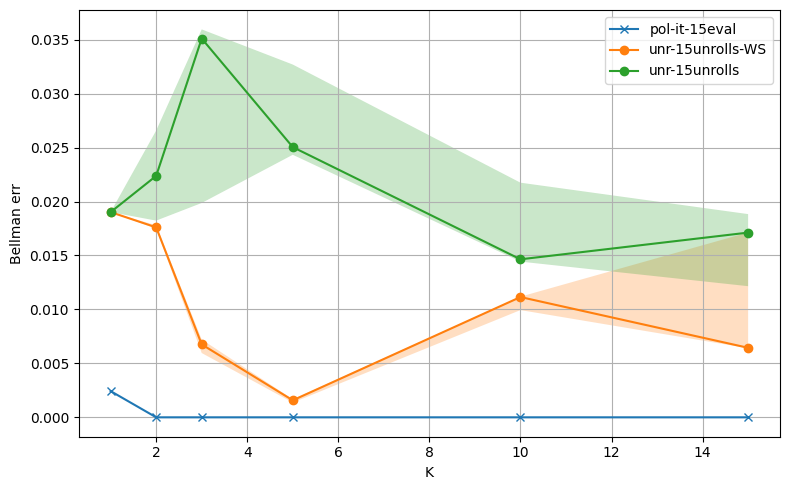

In [26]:
skip_idx = []
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [27]:
# Load data
files = ["filter_order-5_data.npz", "filter_order-10_data.npz", "filter_order-15_data.npz"]

Exps = []
errs1_list = []
errs2_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'Ks' not in locals():  # Guardar solo una vez
        Ks = data["Ks"]
    
    Exps += list(data["Exps"])  # Concatenar listas
    
    errs1_list.append(data["errs1"])
    errs2_list.append(data["errs2"])
    bell_errs_list.append(data["bell_errs"])

# Concatenar por la dimensión 1
errs1 = np.concatenate(errs1_list, axis=1)
errs2 = np.concatenate(errs2_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

## Policy iteration vs Unrolling with/withou WS (only 5 and 10 unrolls) 

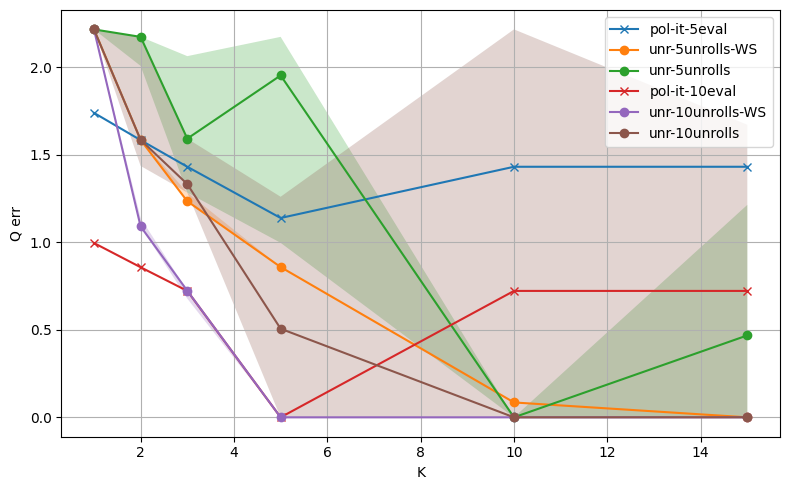

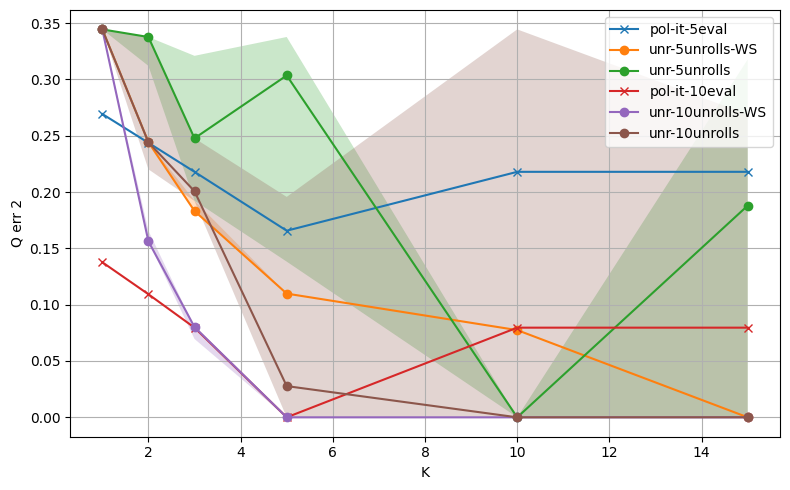

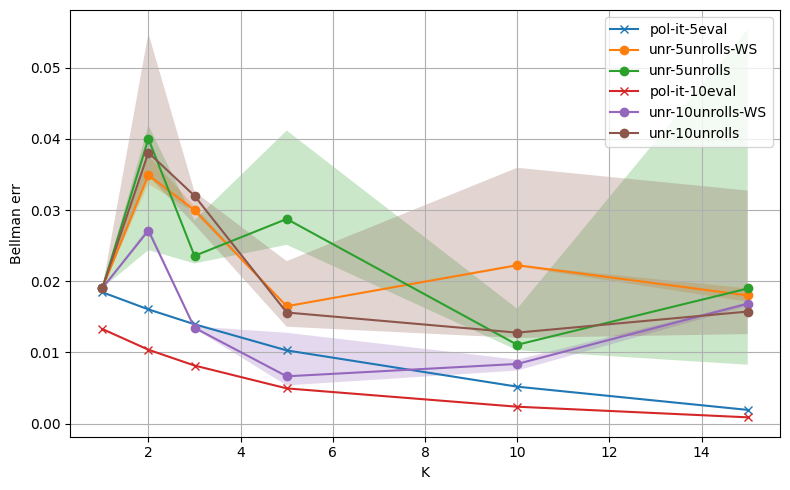

In [33]:
skip_idx = [6, 7, 8]
xlabel = "K"
plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

## Policy iteration vs Unrolling with WS

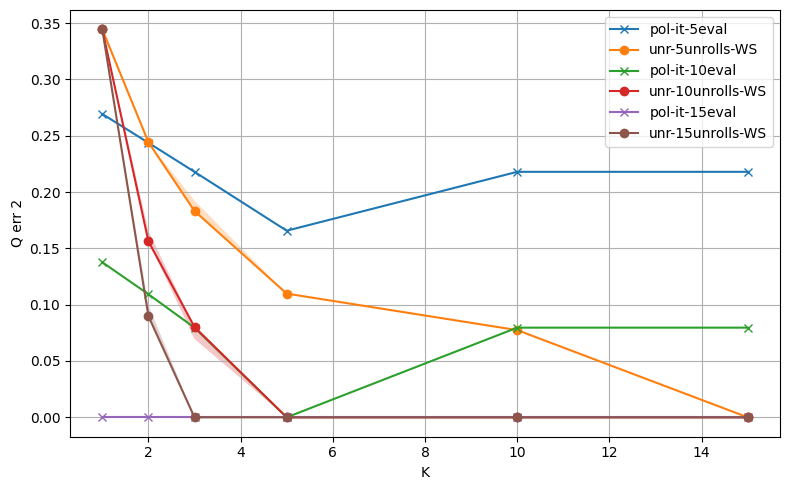

In [34]:
skip_idx = [2, 5, 8]
xlabel = "K"
# plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
# plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

## Policy iteration vs Unrolling with WS

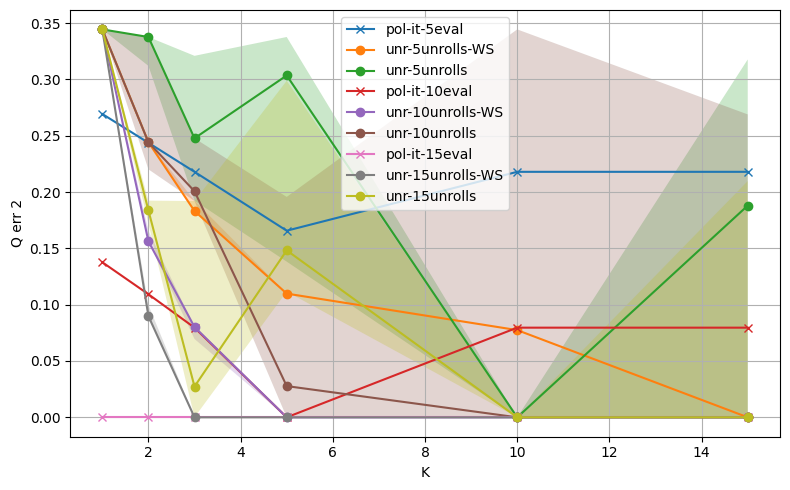

In [40]:
skip_idx = []
xlabel = "K"
# plot_errors(errs1, Ks, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, Ks, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
# plot_errors(bell_errs, Ks, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')